In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from sklearn.linear_model import LinearRegression

Dataset from https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

Source: Data Source :http://data.seoul.go.kr/ SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

In [2]:
df_check = pd.read_csv('SeoulBikeData.csv')

# EDA

In [3]:
df_check.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
# drop columns that are not important in our opinion
df = df_check.drop(["Date", "Holiday", "Seasons"], axis=1)

In [5]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]

In [6]:
df.columns = dataset_cols

In [7]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [8]:
# Change data under functional to 1 & 0
df["functional"] = df["functional"].replace({"Yes": 1, "No": 0})

C:\Users\d3smo\AppData\Local\Temp\ipykernel_21940\1085949079.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["functional"] = df["functional"].replace({"Yes": 1, "No": 0})


In [9]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


In [10]:
# Just looking at the dataset at 12pm currently. 
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

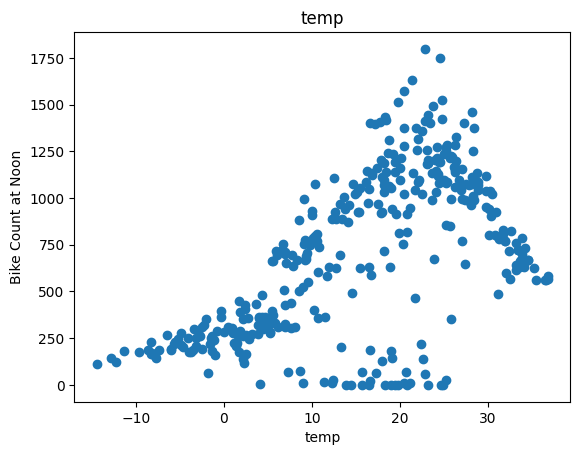

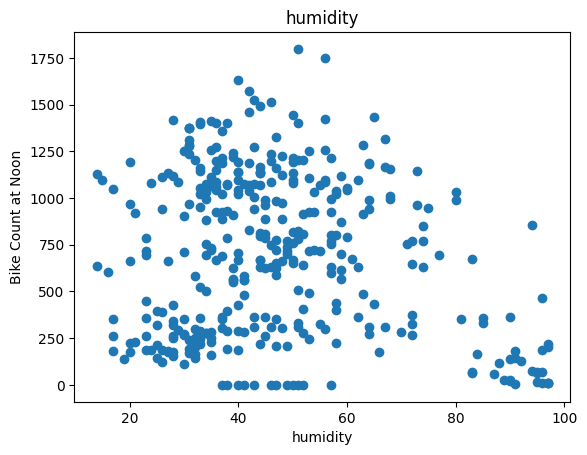

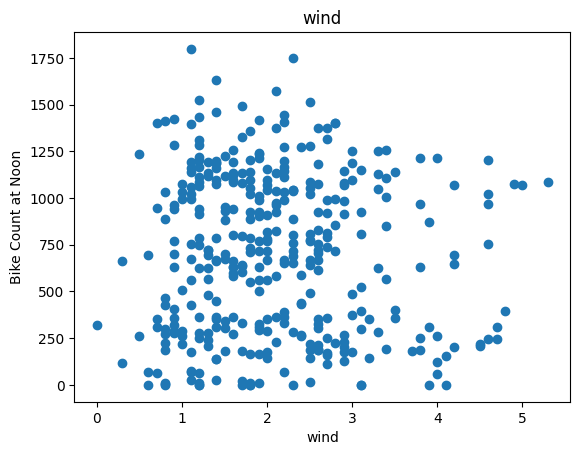

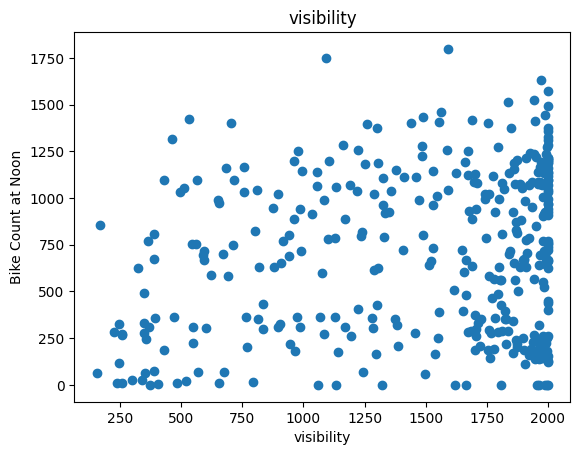

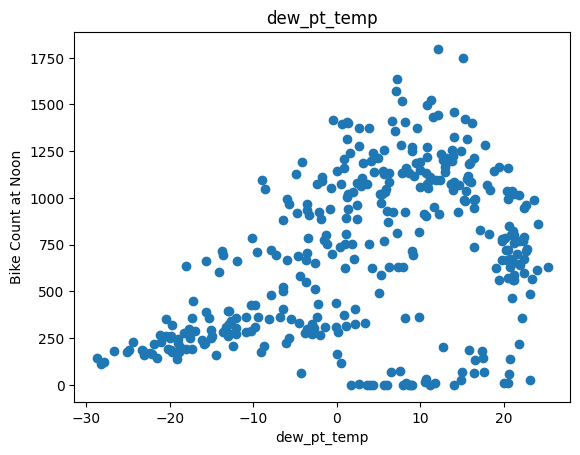

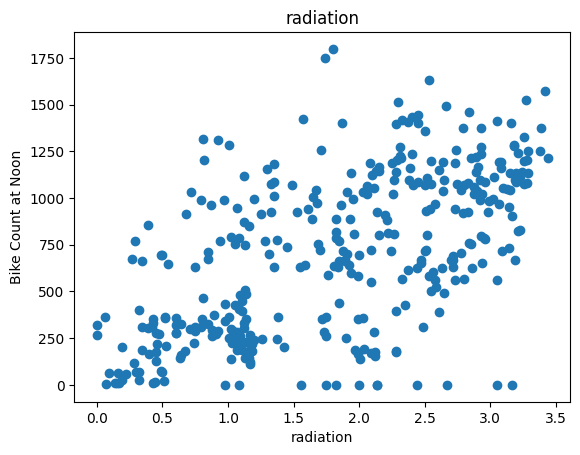

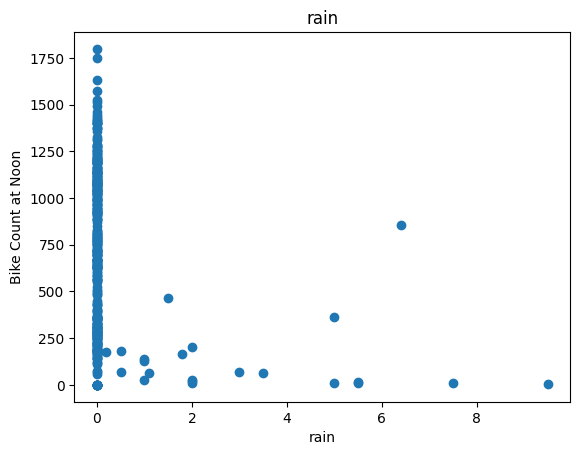

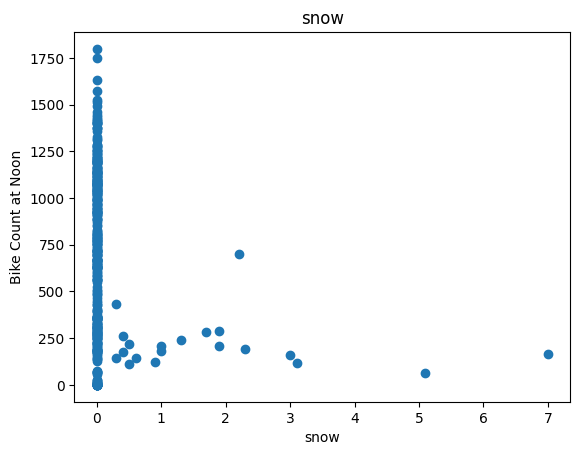

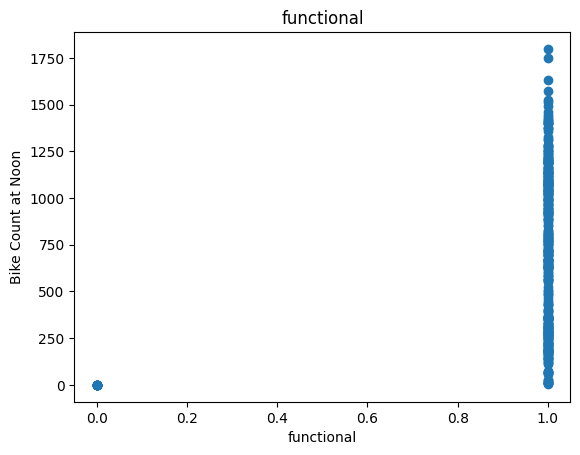

In [11]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

In [12]:
# doesn't looks like it affects the data by much
df = df.drop(["wind", "visibility", "functional"], axis=1)

In [31]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train, validate & test dataset

In [32]:
# 40% will be validate data. 20% will be test data

train_df, val_df, test_df = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

c:\Users\d3smo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [33]:
train_df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
6588,1086,28.9,46,16.1,2.96,0.0,0.0
1908,263,2.2,17,-20.4,1.75,0.0,0.0
1044,174,-3.7,66,-9.1,0.45,0.2,0.4
5196,996,27.0,68,20.5,1.20,0.0,0.0
5028,1158,27.0,68,20.5,1.30,0.0,0.0


In [53]:
import copy
# writing a function to get x & y
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe([c for c in dataframe.columns if c!=y_label]).values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y

In [55]:
_, X_train_temp, y_train_temp = get_xy(train_df, "bike_count", x_labels=["temp"])

In [56]:
_, X_val_temp, y_val_temp = get_xy(val_df, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test_df, "bike_count", x_labels=["temp"])

## Linear Regression

In [57]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [59]:
temp_reg.score(X_test_temp, y_test_temp)

0.35663609579141897

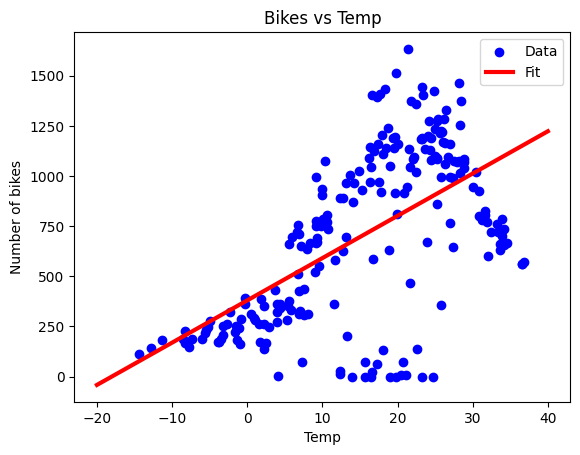

In [60]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

## Multiple Linear Regression

In [61]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

c:\Users\d3smo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [105]:
X_train_all

array([[ 20.  ,  47.  ,   8.3 ,   3.08,   0.  ,   0.  ],
       [ 33.6 ,  62.  ,  25.3 ,   1.35,   0.  ,   0.  ],
       [ -0.3 ,  45.  , -10.8 ,   1.01,   0.  ,   0.  ],
       ...,
       [ -3.4 ,  32.  , -17.7 ,   1.02,   0.  ,   0.  ],
       [ 22.1 ,  36.  ,   6.3 ,   3.2 ,   0.  ,   0.  ],
       [ 16.6 ,  36.  ,   1.4 ,   2.45,   0.  ,   0.  ]])

In [62]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [63]:
all_reg.score(X_test_all, y_test_all)

0.4641289018978798

## Regression with Neural Network

In [77]:
# require to normalize it
# .reshape(-1) to a single vector
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

c:\Users\d3smo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [78]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [79]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [80]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

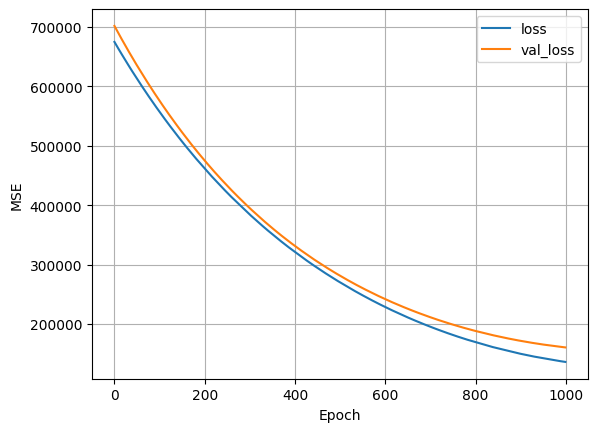

In [81]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


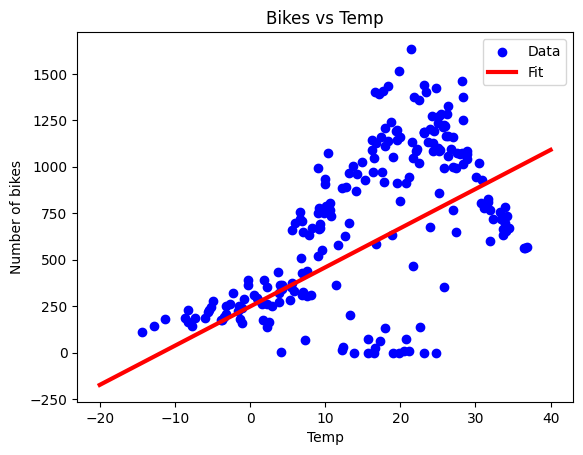

In [82]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

## Linear Regression with Neural Network (Multiple layers)

In [90]:
# require to normalize it
# .reshape(-1) to a single vector
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))


c:\Users\d3smo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [91]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [92]:
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [93]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0, epochs=100
)

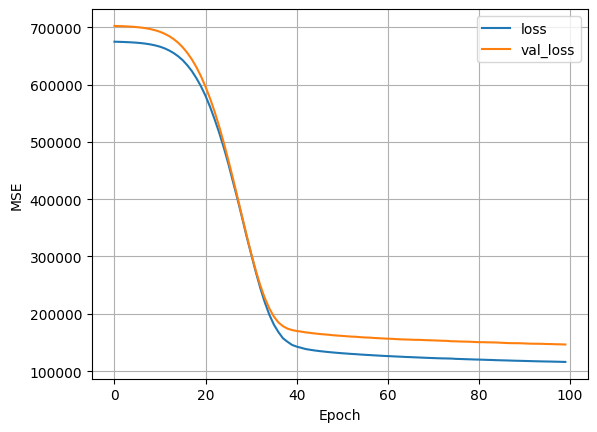

In [94]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


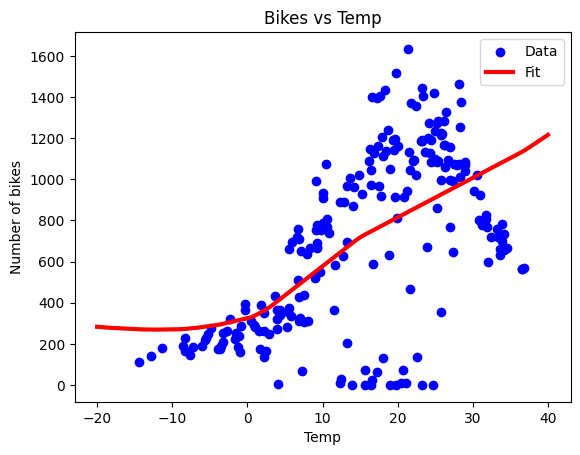

In [95]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

## Multi regression with Neural Network

In [96]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

c:\Users\d3smo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [97]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [98]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
)

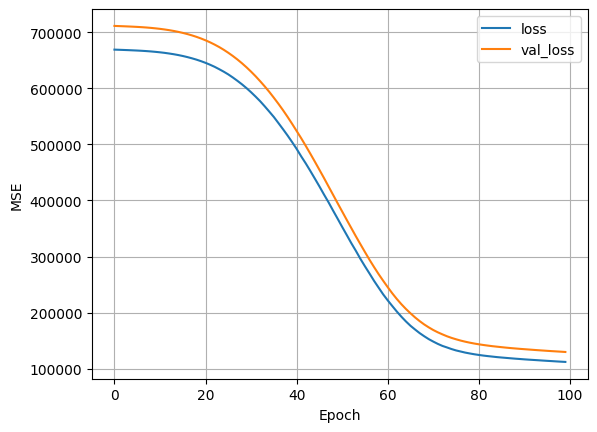

In [99]:
plot_loss(history)

In [100]:
# calculate the MSE for both linear reg and nn
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/stepWARNING:tensorflow:6 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024B1FF71440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [101]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [102]:
MSE(y_pred_lr, y_test_all)

101361.4515531041

In [103]:
MSE(y_pred_nn, y_test_all)

126998.09802399456

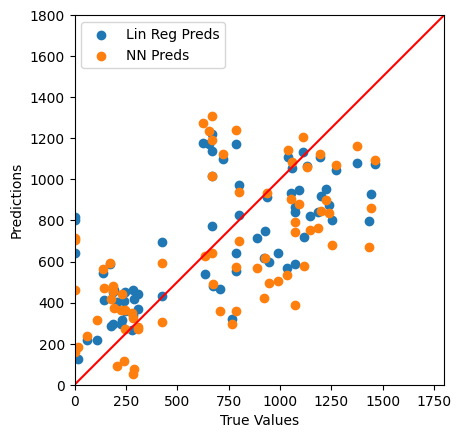

In [104]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")